In [1]:
import numpy as np
import pyhf
import yaml
from pyik.numpyext import rebin
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.interpolate import interp1d
import matplotlib as mtlp
from pyik.mplext import plot_hist
from scipy.stats import norm, poisson,chi2
from scipy.interpolate import splev, splrep
from pyik.numpyext import rebin
import mplhep as hep
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
rc('text', usetex=True)
warnings.filterwarnings("ignore")
pyhf.set_backend("numpy")
filename ="./data.yaml"
stream = open(filename, 'r')
global data 
data= yaml.safe_load(stream)
col= ['#D9296A','#1BA698','#52c9ed','#EB5952','#F2955E','#5196A6']

In [2]:
## Some functions 

LambdaNP=1e+3  #GeV
v= 246.
mh=125.1
mass ={
'ku':2.2e-3,
'kd':4.7e-3,
'ks':95e-3,
'kc':1.275,
}

def kqtoCqH(kq,op):
    if op=='ku'or op=='kd'or op=='ks' or  op=='kc':
        return LambdaNP**2/v**3*(np.sqrt(2.0)*mass[op]*(1-kq))
    else:
        return kq



def CqHtokq(CqH,op):
    if op=='ku'or op=='kd'or op=='ks' or  op=='kc':
        return -(CqH/np.sqrt(2)/LambdaNP**2 *v**3/mass[op])+1
    else:
        return CqH
def CHtokl(CH):
    return 1-2.0*CH*v**4/mh**2/LambdaNP**2

def kltoCH(kl):
    return LambdaNP**2/v**4*mh**2*0.5*(1-kl)
######################################################################
def invert_interval(test_mus, hypo_tests, test_size=0.05):
    cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
    cls_exp = [
        np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)
    ]
    crossing_test_stats = {"exp": [], "obs": None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats["exp"].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats["obs"] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats
######################################################################

def XS(CqH,f,W):
    if f=='kl':
        kq=CHtokl(CqH)
    else:
         kq=CqHtokq(CqH,f)            
    R=data[f][W]['XSA0']+data[f][W]['XSA1']*kq+data[f][W]['XSA2']*kq**2
    return R*data['kl'][W]['XSSM']- data['kl'][W]['XSSM']

def BR(CqH,f):
    kq=CqHtokq(CqH,f)
    Rga= data[f]['Width']['gagaA0']+ data[f]['Width']['gagaA1']*kq+data[f]['Width']['gagaA2']*kq**2
    Rtot= data[f]['Width']['totA0']+ data[f]['Width']['totA1']*kq+data[f]['Width']['totA2']*kq**2
    HiggsFullwidth = data['Higgs']['width']*Rtot
    return 2*(data['Higgs']['BRbbSM']*Rga*data['Higgs']['BRgagaSM'])/Rtot


def plot_result(ax,obs_scan_res,kk,W,op,CL):
    label_dict ={
    'ku':'C_{uH}',
    'kd':'C_{dH}',
    'ks':'C_{sH}',
    'kc':'C_{cH}',
    'cu':'c_u',
    'cuu':'c_{uu}',
    'cd':'c_d',
    'cdd':'c_{dd}',
    'cs':'c_s',
    'css':'c_{ss}',
    'cc':'c_c',
    'ccc':'c_{cc}',
    'kl' :'\kappa_\lambda'
    }
    etck=  splrep(kk, obs_scan_res[:,2],s=0)
    p1_sig_tck= splrep(kk, obs_scan_res[:,3],s=0)
    m1_sig_tck= splrep(kk, obs_scan_res[:,1],s=0)
    p2_sig_tck=splrep(kk, obs_scan_res[:,4],s=0)
    m2_sig_tck= splrep(kk, obs_scan_res[:,0],s=0)
    
    

   
    if op=='kl':
         ax.set_xlabel(r"$%s$"%(label_dict[op]))
    else:
        ax.set_xlabel(r"$%s$[$\mathrm{TeV}^{-2}$]"%(label_dict[op]))
    ax.set_ylabel(r"$\sigma \cdot \mathrm{BR}_{b \bar b \gamma \gamma }$ @ %d %sCL [fb]"%(CL, '\%'))
    s= kk[-1]

    x= np.linspace(kk[0],kk[-1], 500)
    xx=np.linspace(kk[0],kk[-1], 1000)
    
    expec=splev(x,etck)
    p1_sig= splev(x,p1_sig_tck)
    p2_sig =splev(x,p2_sig_tck)
    m2_sig =splev(x,m2_sig_tck)
    m1_sig =splev(x,m1_sig_tck)
    
    
    
    XSr= lambda y: (XS(y,op,"%dTeV"%(W))+data['kl']["%dTeV"%(W)]['XSSM'])*BR(y,op)


    plt.fill_between(x,XSr(x)*m2_sig,XSr(x)*p2_sig,facecolor='y',alpha=0.5 , label =r"$\pm 2 \sigma$")
    #
    plt.fill_between(x,XSr(x)*m1_sig,XSr(x)*p1_sig,facecolor='g',alpha=0.5 , label =r"$\pm 1 \sigma$")
    #####
    plt.plot(x,XSr(x)*expec,color='k',ls='--',lw=1.5, label="Expected" )
    ###
    plt.plot(xx,XSr(xx),lw=1.5, label="Theory" ,color='#31455b')
    plt.fill_between(xx,XSr(xx)*0.95,XSr(xx)*1.05,facecolor='#31455b',alpha=0.5)

    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    plt.xlim(x[0],x[-1])
    plt.grid(ls=':',color='#808080')
    plt.legend()

In [34]:



def sig_lambda(kl,kq):
    return  XS(kltoCH(kl),'kl',"%dTeV"%(W))*BR(kqtoCqH(kq,op),op)*L*0.2
def sig(kq):
    return XS(kqtoCqH(kq,op),op,"%dTeV"%(W))*BR(kqtoCqH(kq,op),op)*L


def scan(CqH,CH):
    kq=CqHtokq(CqH,op)
    kl=CHtokl(CH)
    # cat 1 kq, cat2 intference, cat3 triangle
    event_kappad0 = XS(kqtoCqH(800,op),op,"%dTeV"%(W))*BR(kqtoCqH(800,op),op)*6000
    effkappad=  [125/event_kappad0,29/event_kappad0,43/event_kappad0 ]
    event_int0 = (2.6991569822478835E-002*1000*6000)*BR(kqtoCqH(1.0,op),op)
    eff_int = np.array([25/event_int0,37/event_int0,31/event_int0])
    event_tri = (5.5257057414026915E-003*1000*6000) *BR(kqtoCqH(1.0,op),op)
    eff_tri = np.array([4/event_tri,6/event_tri,10/event_tri])
    signal_kl = 34.80*(-eff_int*1.3441884098642738*kl+ 0.2734554764015495*kl**2*eff_tri)*BR(kqtoCqH(kq,op),op)*L
    signal_d= [ 89/6e3*L+sig(kq)*effkappad[0]+signal_kl[0]\
               ,84/6e3*L+sig(kq)*effkappad[1]+signal_kl[1]\
               ,95/6e3*L+sig(kq)*effkappad[2]+signal_kl[2]] 
    bkg_d= [(223+761)*L/6000,(141+276)*L/6000,(210+387)*L/6000]  # QQaa and bbxaa for the three categories
    bkg_un_d = [(223+761)*L/6000*0.05,(141+276)*L/6000*0.05,(210+387)*L/6000*0.05]  # uncertainty of the background, set to 5%.
    model = pyhf.simplemodels.hepdata_like(
        signal_data=signal_d, bkg_data=bkg_d, bkg_uncerts=bkg_un_d
    )
# mu' = 0: background-like
    pars_bkg = model.config.suggested_init()
    pars_bkg[model.config.poi_index] = 0.0
    # mu' = 1: signal-like
    pars_sig = model.config.suggested_init()
    pars_sig[model.config.poi_index] = 1.0

    # data = model.expected_data(model.config.suggested_init())
    data=  pyhf.tensorlib.astensor(bkg_d + model.config.auxdata)

    poi_vals = np.linspace(0, 5.0, 50)
    # print(model.config.suggested_bounds())
    results = [
        pyhf.infer.hypotest(test_poi,
        data,
        model,
        model.config.suggested_init(),
        # par_bounds=[(0, 30), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0)],
        qtilde=True,
        return_expected_set=True)
        for test_poi in poi_vals
    ]
    invresults = invert_interval(poi_vals, results,test_size= 1-CL*1e-2) # 0.32 , 0.05,0.003
    expec=invresults['exp']
    return expec

In [13]:
def scan1DkappaL(kl):
    CH=kltoCH(kl)
   # kl=CHtokl(CH)
    # cat 1 kq, cat2 i ntference, cat3 triangle
    event_int0 = (2.6991569822478835E-002*1000*6000)*BR(kqtoCqH(1.0,op),op)
    eff_int = np.array([43/event_int0,36/event_int0])
    event_tri = (5.5257057414026915E-003*1000*6000) *BR(kqtoCqH(1.0,op),op)
    eff_tri = np.array([6/event_tri,12/event_tri])
    signal_kl = 34.80*(-eff_int*1.3441884098642738*kl+ 0.2734554764015495*kl**2*eff_tri)*BR(kqtoCqH(1.0,'kd'),'kd')*L
    signal_d= [95/6000*L+signal_kl[0]\
               ,69/6000*L+signal_kl[1]] 
    bkg_d= [(156+384)*L/6000,(228+529)*L/6000]  # QQaa and bbxaa for the three categories
    bkg_un_d= [(156+384)*L/6000*0.05,(228+529)*L/6000*0.05]
    model = pyhf.simplemodels.hepdata_like(
        signal_data=signal_d, bkg_data=bkg_d, bkg_uncerts=bkg_un_d
    )

# mu' = 0: background-like
    pars_bkg = model.config.suggested_init()
    pars_bkg[model.config.poi_index] = 0.0
    # mu' = 1: signal-like
    pars_sig = model.config.suggested_init()
    pars_sig[model.config.poi_index] = 1.0

    # data = model.expected_data(model.config.suggested_init())
    data=  pyhf.tensorlib.astensor(bkg_d + model.config.auxdata)

    poi_vals = np.linspace(0, 8.0, 50)
    # print(model.config.suggested_bounds())
    results = [
        pyhf.infer.hypotest(test_poi,
        data,
        model,
        model.config.suggested_init(),
        # par_bounds=[(0, 30), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0)],
        qtilde=True,
        return_expected_set=True)
        for test_poi in poi_vals
    ]
    invresults = invert_interval(poi_vals, results,test_size= 1-CL*1e-2) # 0.32 , 0.05,0.003
    expec=invresults['exp']
    return expec

array([0.13611835, 0.12847125, 0.09023576])

In [37]:
W = 14  # TeV  COM energy
op= "kd"      # quark flavour
flav = 'down'
L= 6000.00   #inv fb
CL = 99 #  68% (1 sigma), 95% (2 sigma) and 99.7 % (3 sigma)
n=5
m=4
kkq =np.linspace(kqtoCqH(800,op),kqtoCqH(-800,op), n) # put them backwards 
kkl = np.linspace(kltoCH(4),CHtokl(-2), m)
Kq,Kl= np.meshgrid(kkq,kkl)
scan_res= np.empty_like(Kq)
for i in range(n):
    for j in range(m):
        scan_res[j,i] = (scan(kkq[i],kkl[j]))[2] 
    


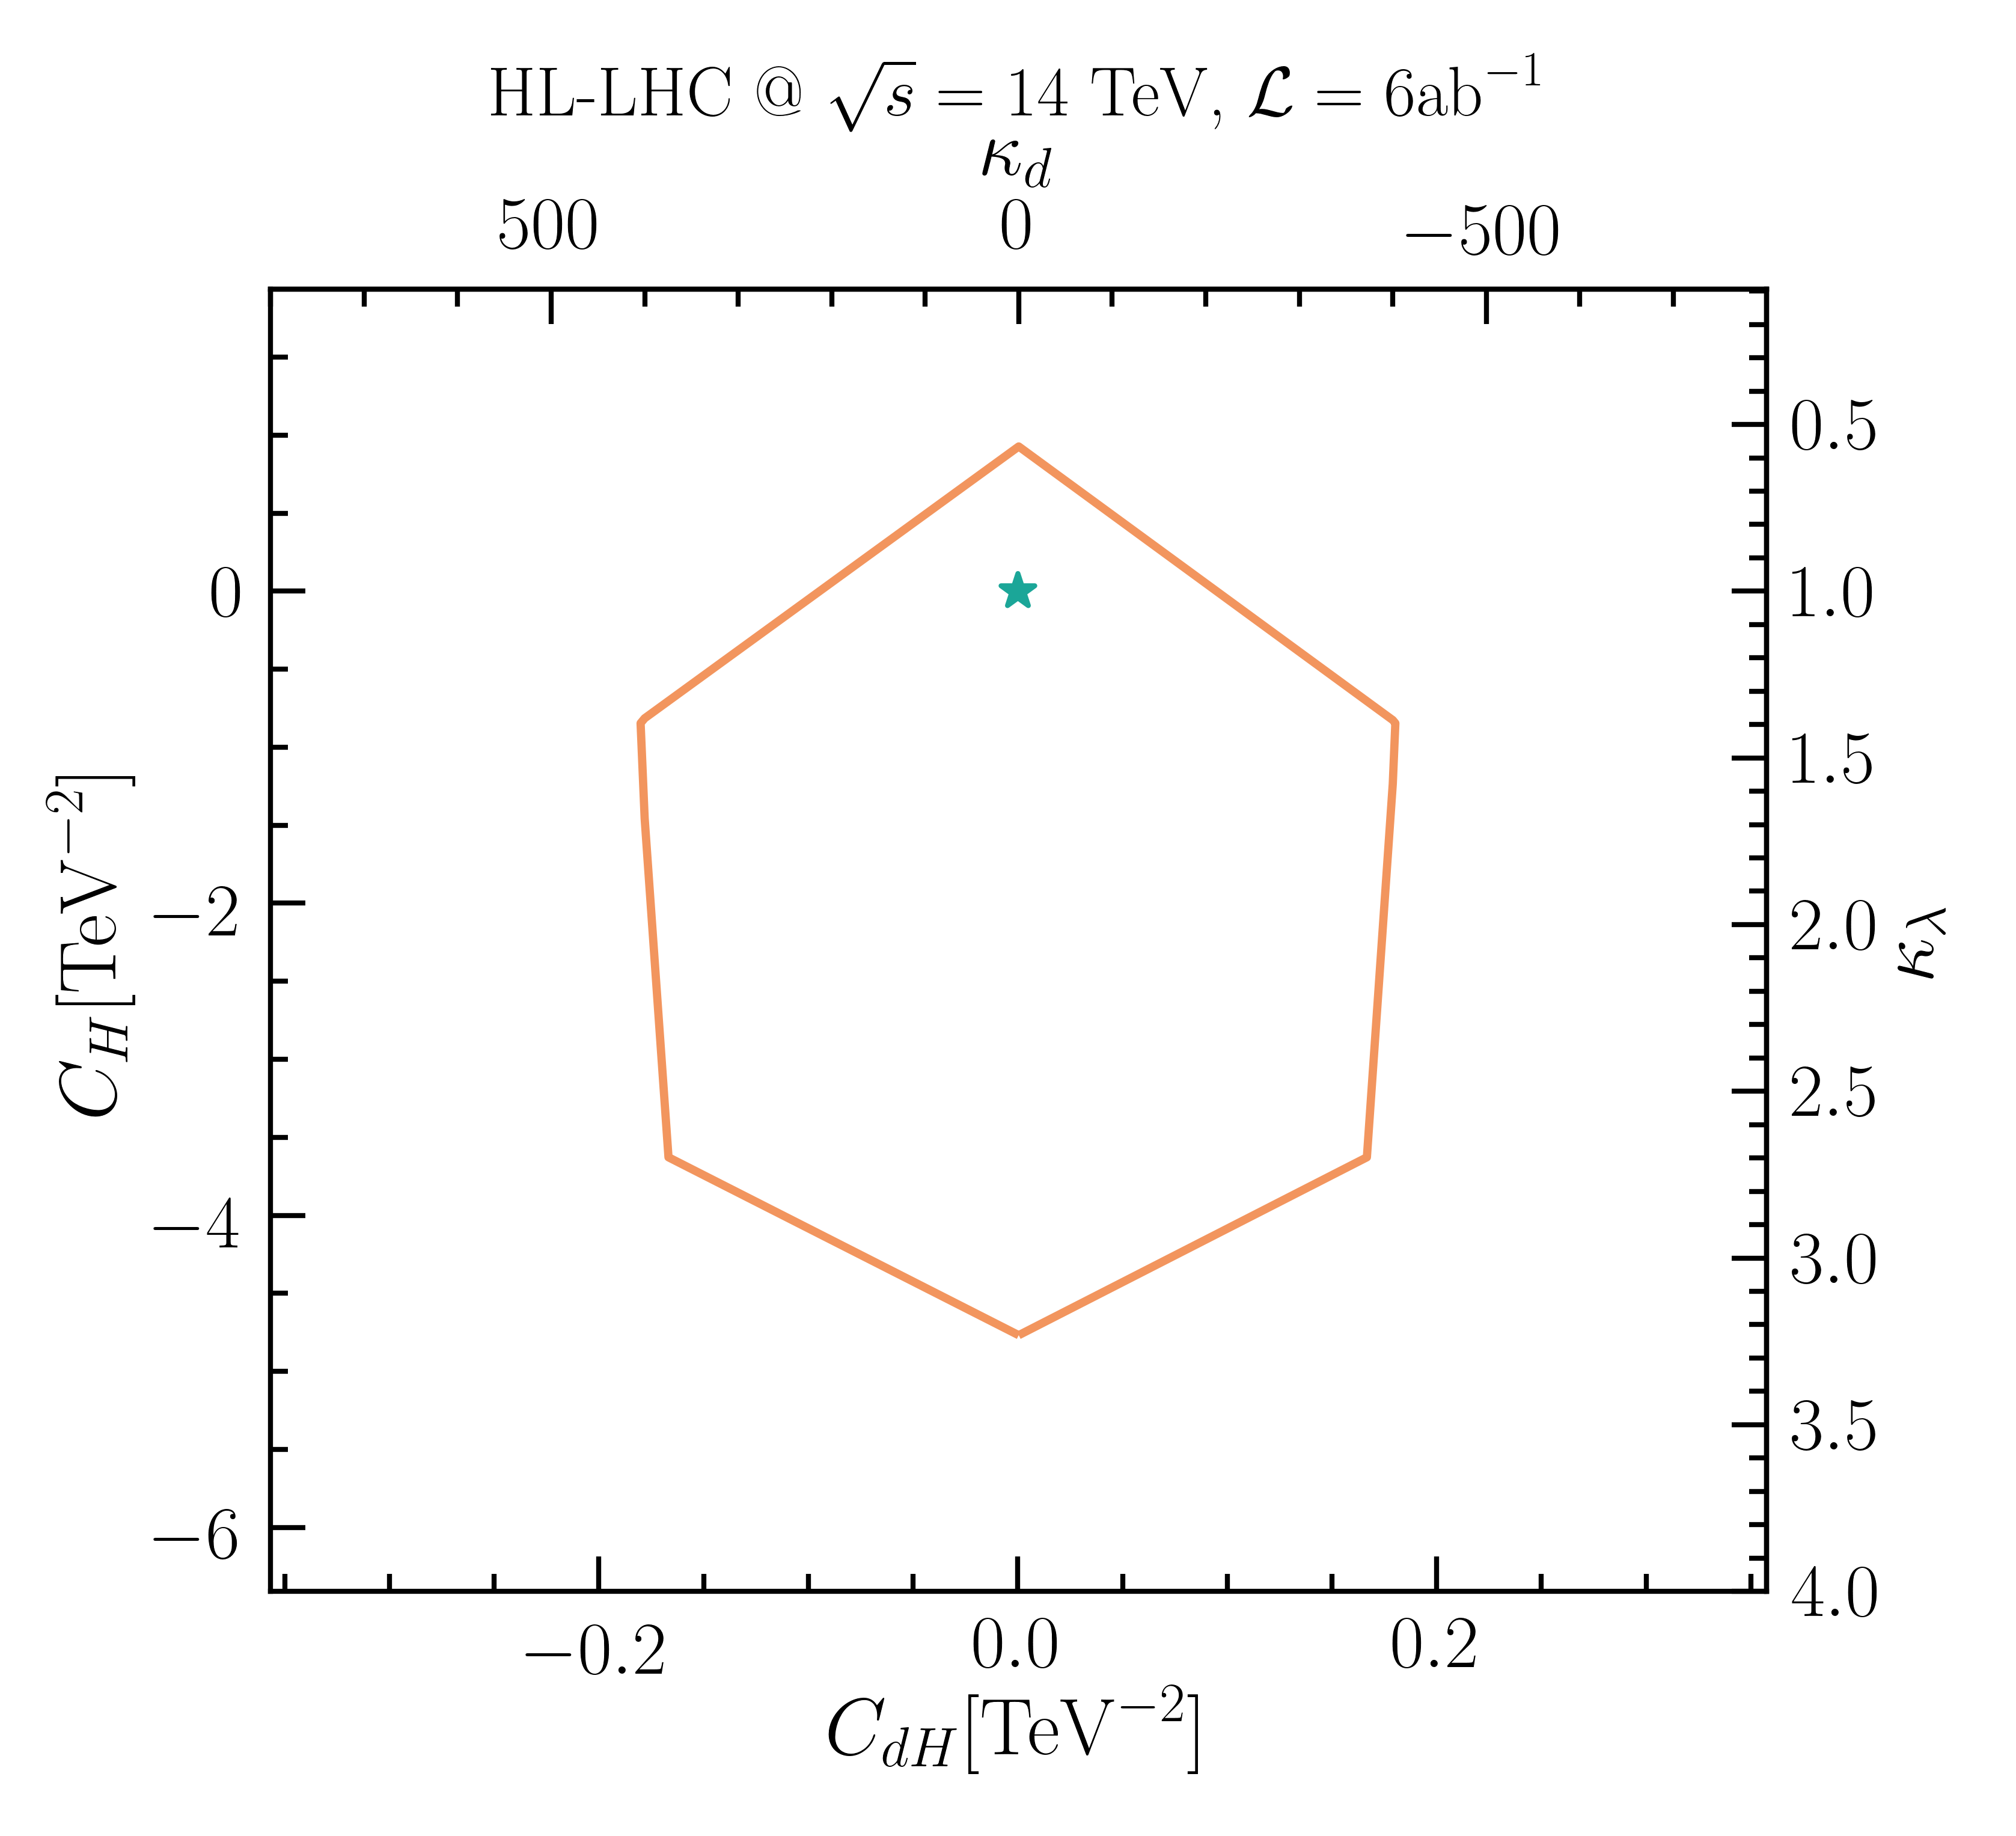

In [38]:
plt.style.use(hep.style.LHCb2)
fig, ax = plt.subplots(1, figsize=(11, 10))

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off)
)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off)
)

#plt.ylim(-6,2)
ax.set_xlabel(r"$C_{dH} [\mathrm{TeV}^{-2}]$")
ax.set_ylabel(r"$C_H [\mathrm{TeV}^{-2}]$")
#plt.contourf(Kq,Kl,scan_res,levels=[1,100],colors=col[4],alpha=0.3)
plt.contour(Kq,Kl,scan_res,levels=[1,100],colors=col[4])
def xinverse(x):
    return kqtoCqH(x,'kd')

def xforward(x):
    return CqHtokq(x,'kd')
secax = ax.secondary_xaxis('top', functions=(xforward, xinverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r"$\kappa_d$")

secay = ax.secondary_yaxis('right', functions=(CHtokl, kltoCH))
secay.yaxis.set_minor_locator(AutoMinorLocator())
secay.set_ylabel(r"$\kappa_\lambda$")

#plt.grid(ls=':',color='#808080')
ax.scatter(0.0, 0.0, s=200, marker='*',color=col[1])
plt.title(r"HL-LHC @ $\sqrt{s}=%d$ TeV, $\mathcal L= 6 \mathrm{ab}^{-1}$"%(W))
plt.gcf().tight_layout()
plt.show()

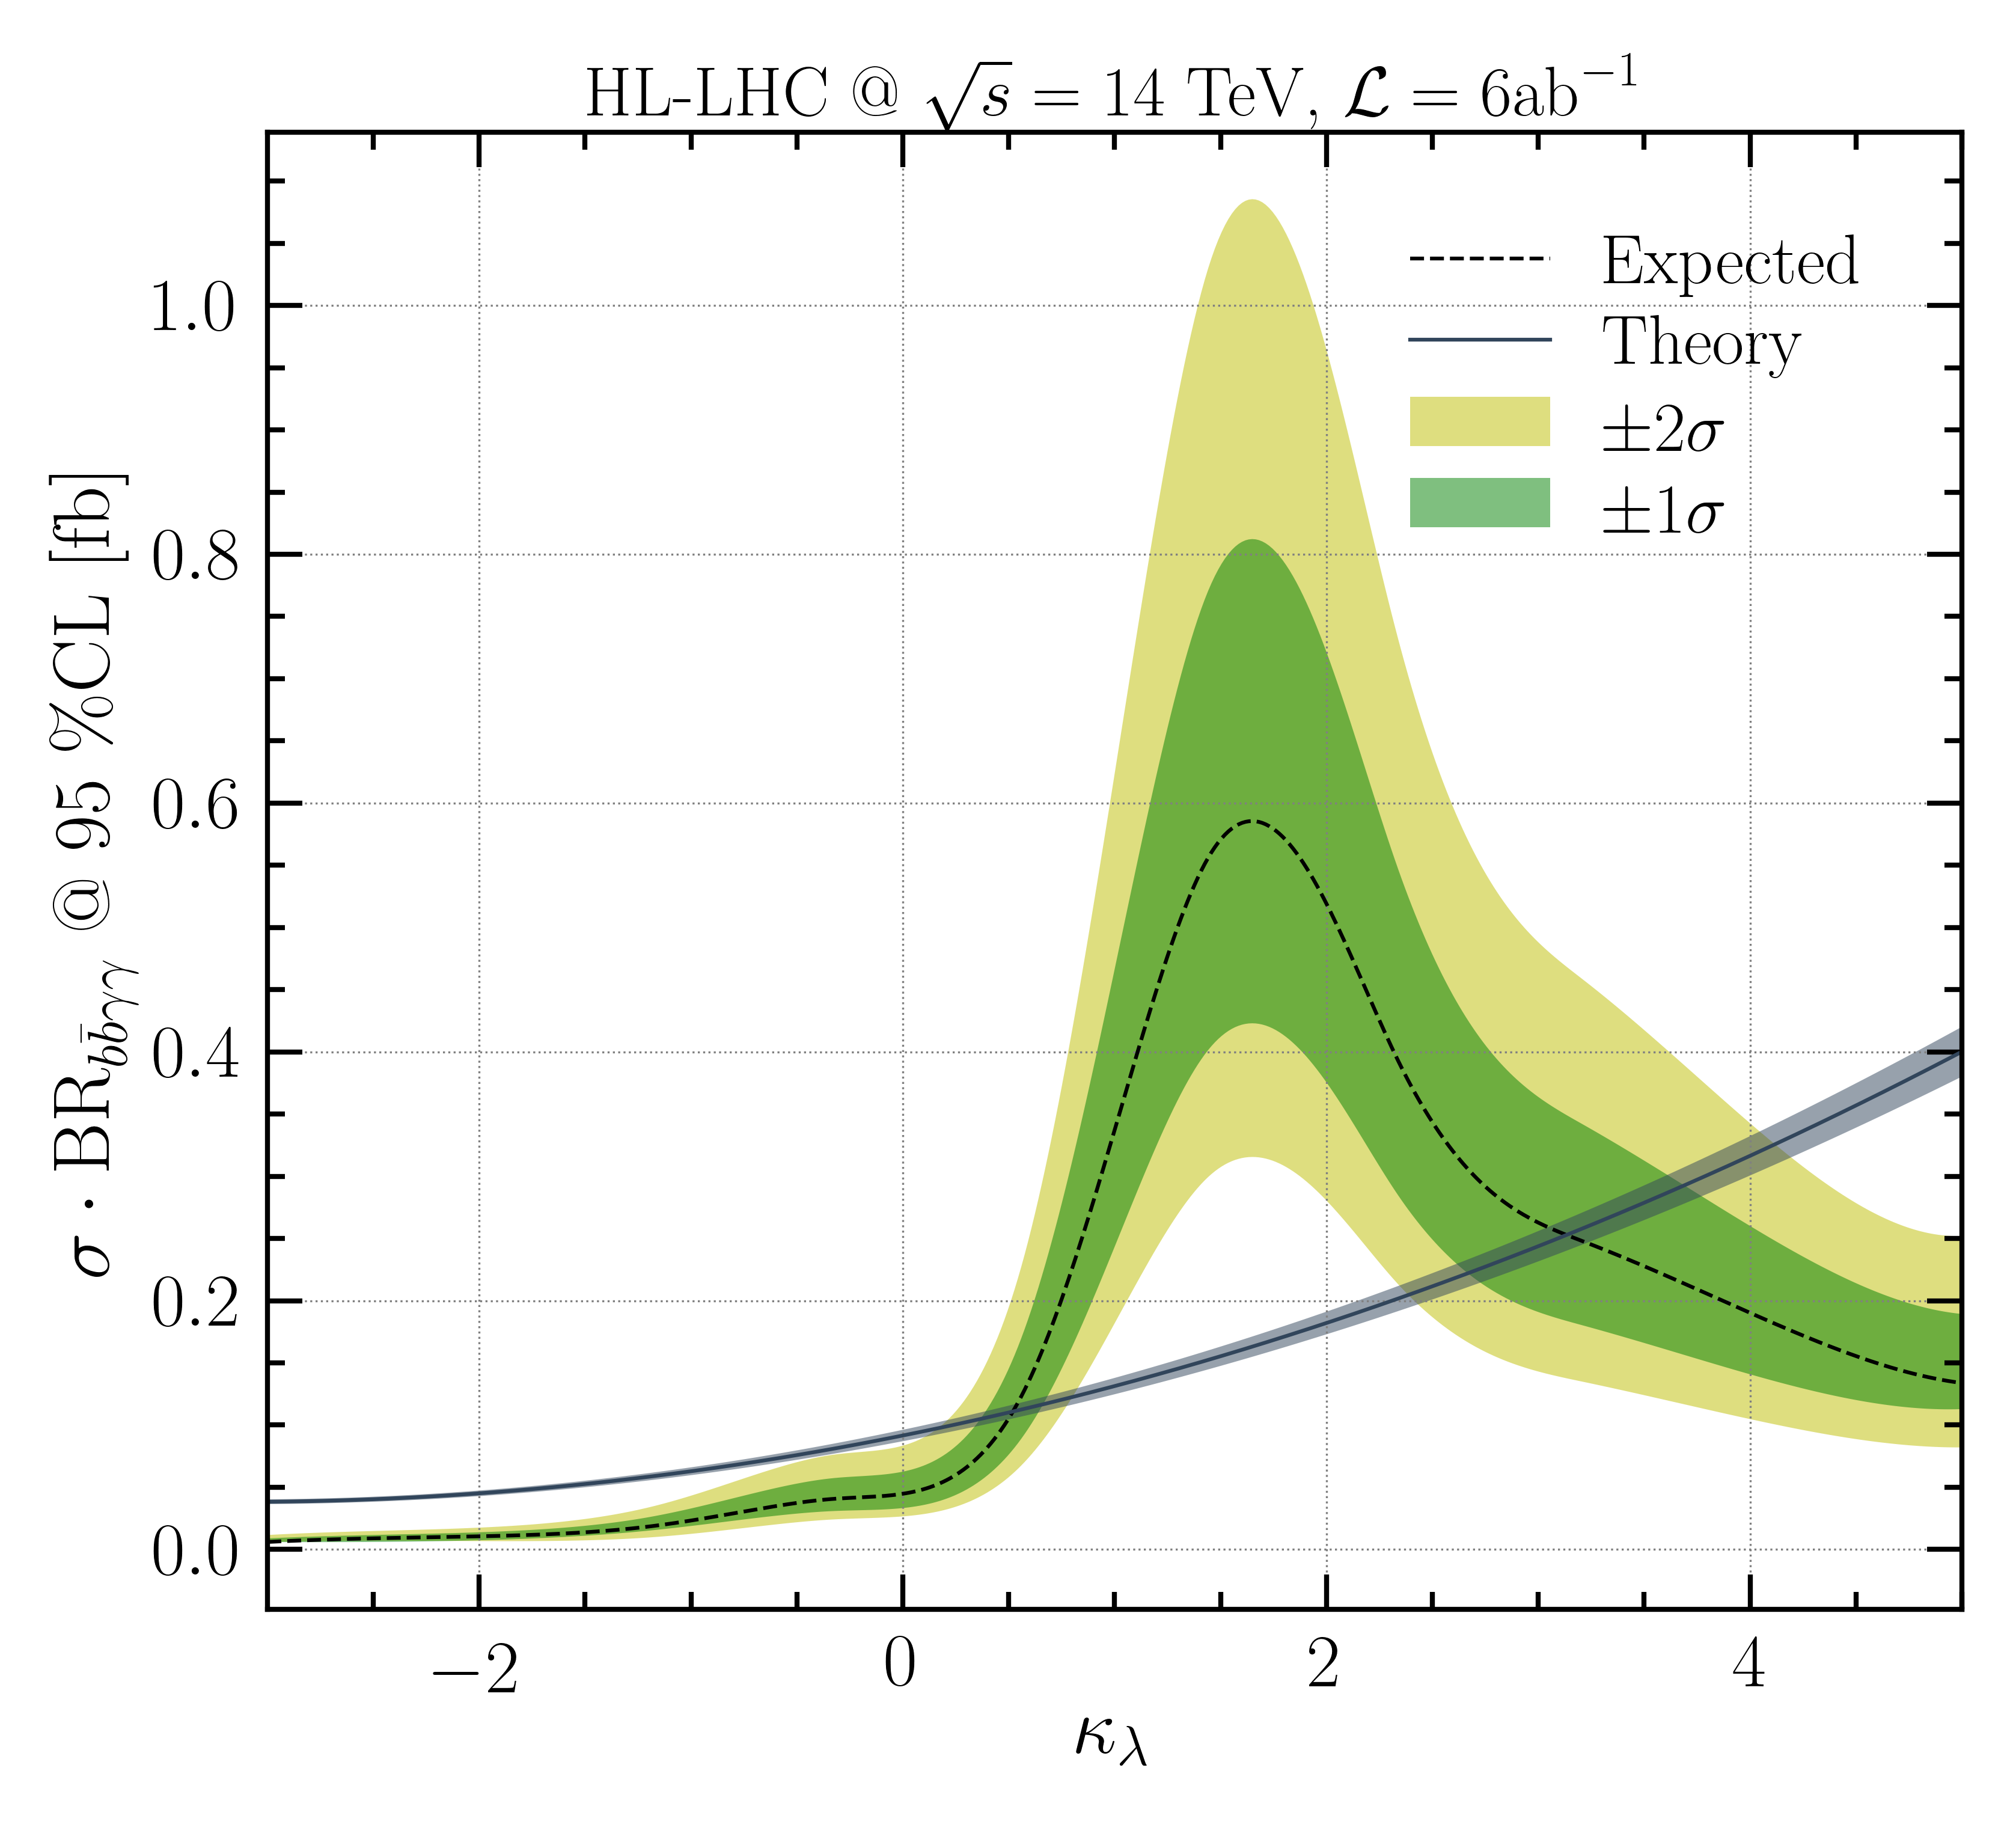

In [14]:
W = 14  # TeV  COM energy
op= "kl"      # quark flavour
flav = 'up'
L= 6000.00   #inv fb
CL = 95 #  68% (1 sigma), 95% (2 sigma) and 99.7 % (3 sigma)
#kkq =np.linspace(kqtoCqH(2000,op),kqtoCqH(-2000,op), 20) # put them backwards 
m=10
#kkl = np.linspace(kltoCH(5),CHtokl(-3), m)
kkl = np.linspace(-3,5, m)
obs_scan_res= np.array([
scan1DkappaL(k) for k in kkl
 ])

plt.style.use(hep.style.LHCb2)
fig, ax = plt.subplots(1, figsize=(11, 10))
plot_result(ax,obs_scan_res,kkl,W,op,CL)

plt.title(r"HL-LHC @ $\sqrt{s}=%d$ TeV, $\mathcal L= 6 \mathrm{ab}^{-1}$"%(W))

plt.gcf().tight_layout()

plt.show()